# Classification

**If you are a Colab user**

If you use Google Colab, you can uncomment the following cell to mount your Google Drive to Colab.
After that, Clab can read/write files and data in your Google Drive

please change the current directory to be the folder that you save your Notebook and
data folder. For example, I save my Colab files and data in the following location

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

**install imbalanced-learn**

Imbalanced-learn (imported as imblearn) is an open source, MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.
https://imbalanced-learn.org/stable/

Using the installation command in the terminal (if your computer is a Linux system) or other command-line interpreter application like Anaconda Prompt (if your computer is a Windows system):

*conda install -c conda-forge imbalanced-learn*

If you would like to install it from this notebook, you uncomment the following cell and execute it

In [2]:
#!pip3 install imbalanced-learn

**Set up standards for the remainder of the notebook**

In [3]:
## import libraries and tools ##

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn

import imblearn

# to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

## The AI4I2020 Predictive Maintenance Dataset

AI4I2020 Preditive Maintenance Dataset

https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

The dataset consists of 10,000 data points stored as rows with 14 features in columns
<ol>
<li>UID: unique identifier ranging from 1 to 10,000 </il>

<li>product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number</il>

<li> Type: a letter L, M, or H

<li>air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K</il>

<li>process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.</il>

<li>rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise.</il>

<li>torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.</il>

<li>tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
</ol>

The machine failure consists of five independent failure modes:
<ol>
<li>tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).</il>

<li>heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.</il>

<li>power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.</il>

<li>overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.</il>

<li>random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
</ol>

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

### Load and understand data

In [4]:
## read the dataset in csv format ##

df = pd.read_csv('Data/ai4i2020.csv')


In [5]:
# check the variable names, data type, and data size

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
# change the integer data type of numerical features to float data type
df['Tool wear [min]'] = df['Tool wear [min]'].astype('float64')
df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].astype('float64')

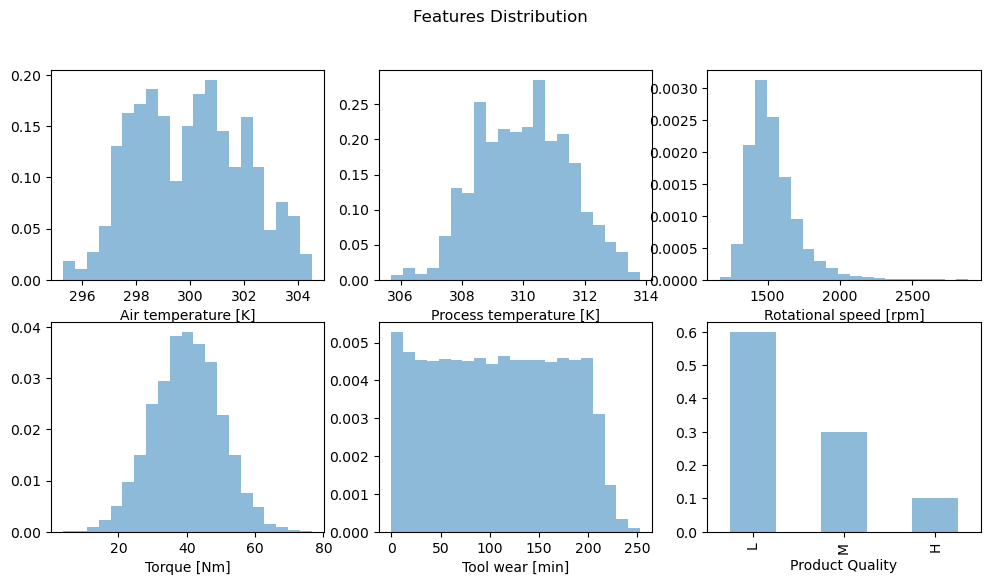

In [7]:
# visually check features

features = df.iloc[:,2:8] # features that are rows 2-7 in the original dataset. There are six features in total
num_features = features.iloc[:,1:6] # among the six features, columns 1-5 are numerical features, and column 0 is a categorical feature

# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, 
                        ncols=3, 
                        figsize=(12,6))
fig.suptitle('Features Distribution')
for j, feature in enumerate(num_features):
    row = j//3
    col = j-j//3*3
    axs[row,col].hist(num_features[feature],
                      bins=21,
                      alpha=0.5,
                      density=True)
    axs[row,col].set_xlabel(feature)

# column chart of the categorical feature
type_count = features.Type.value_counts(normalize=True)
type_count.plot(kind='bar',alpha=0.5)
plt.xlabel('Product Quality')

plt.show();


In [8]:
# review the two target variables, Machine failure and Failure type (recoded from the five dummy variables of failure types)

# create a new column to save categories of failure mode: 0: no failure, 1: TWF, 2: HDF, 3: PWF, 4: OSF, 5: RNF
# this new column meets the desired data format for sklean
target = df.iloc[:,8:14]
target['Failure mode']=0 # default value is '0', meaning no failure
for i in range(1,6):
    target.loc[(target.iloc[:,i]==1),'Failure mode']=i # 'Failure mode'=i if the ith failure type ==1

# check the relationship between `Machine failure' and 'Failure mode'
pd.crosstab(target['Machine failure'],
            target['Failure mode'], 
            values=target['Failure mode'], 
            aggfunc='count')

# Add a column to the dataset, saving the derived failure mode
df['Failure mode']=target['Failure mode']
# There are 9 observations that have machine failure but no failure mode has been specified.
# There are 18 observations that have no machine failure but the failure modee is RNF.
# There is only 1 observation of machine failure whose failure mode is RNF.
# In total, 28 observations seem to provide no useful information for this study, which can be excluded

Failure mode,0,1,2,3,4,5
Machine failure,,,,,,
0,9643.0,NaN,NaN,NaN,NaN,18.0
1,9.0,42.0,106.0,83.0,98.0,1.0


### Pre-process data

A few data pre-processing is required here, including filtering out outliers and balancing data

#### Data filtering

In [9]:
# We exclude these 28 observations 
obs_excluded = (target['Machine failure']==1)&(target['Failure mode']==0) | (target['Failure mode']==5)
df_proc = df[~obs_excluded]
df_proc

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Failure mode
0,1,M14860,M,298.1,308.6,1551.0,42.8,0.0,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408.0,46.3,3.0,0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498.0,49.4,5.0,0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433.0,39.5,7.0,0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408.0,40.0,9.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604.0,29.5,14.0,0,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632.0,31.8,17.0,0,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645.0,33.4,22.0,0,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408.0,48.5,25.0,0,0,0,0,0,0,0


In [10]:
# We exclude these 28 observations 
obs_excluded = (target['Machine failure']==1)&(target['Failure mode']==0) | (target['Failure mode']==5)
df_proc = df[~obs_excluded]

# drop columns that won't be used by this study
df_proc = df_proc.drop(columns=['UDI','Product ID','TWF','HDF','PWF','OSF','RNF'])

# check the updated dataset
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9972 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9972 non-null   object 
 1   Air temperature [K]      9972 non-null   float64
 2   Process temperature [K]  9972 non-null   float64
 3   Rotational speed [rpm]   9972 non-null   float64
 4   Torque [Nm]              9972 non-null   float64
 5   Tool wear [min]          9972 non-null   float64
 6   Machine failure          9972 non-null   int64  
 7   Failure mode             9972 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 701.2+ KB


#### Data rebalancing

In [11]:
# Let's check the distribution of Failure mode in the dataset
print('Sample size by class:')
df_proc['Failure mode'].value_counts().sort_index()
# failure samples counts 3.3%. the dataset is highly unbalanced. 

# we resample data to address the class-inbalanced dataset using
# Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTNC).
# We keep the ratio of non-failure to failure as 80:20
# We note that imblearn is not the best solution. But let's use it temporarily
from imblearn.over_sampling import SMOTENC

n_neg = (df_proc['Failure mode']==0).sum() # the sample size for class 0 of 'Failure mode'
n_pcs = round((round(n_neg/0.8)-n_neg)/4)  #sample size for each of clases 1~4 of 'Failure mode'

# Define the target sample distribution
balance_cause = {0:n_neg,
                 1:n_pcs,
                 2:n_pcs,
                 3:n_pcs,
                 4:n_pcs}

# define 
sm = SMOTENC(categorical_features=[0,6,7], # specify columns that are categorical variables
             sampling_strategy=balance_cause,  
             random_state=0)

df_resmp, y_resmp = sm.fit_resample(df_proc, 
                                    df_proc['Failure mode']) # sampling from df_proc according to the distribution of column 'Failure mode'


print('\nSample size by class - after resampling:')
print(y_resmp.value_counts().sort_index())

Sample size by class:


Failure mode
0    9643
1      42
2     106
3      83
4      98
Name: count, dtype: int64


Sample size by class - after resampling:
Failure mode
0    9643
1     603
2     603
3     603
4     603
Name: count, dtype: int64


#### one-hot encoding of the categorical feature

In [12]:
# recode the categorical variable "Type" as dummy variables:
df_encoded = pd.get_dummies(df_resmp, 
                            columns=['Type'], 
                            drop_first=False,
                            dtype=int)  # drop_first=True avoids dummy trap

# move the dummies in front of the response variables
df_encoded = df_encoded.iloc[:,[0,1,2,3,4,7,8,9,5,6]]
df_encoded.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Machine failure,Failure mode
0,298.1,308.6,1551.0,42.8,0.0,0,0,1,0,0
1,298.2,308.7,1408.0,46.3,3.0,0,1,0,0,0
2,298.1,308.5,1498.0,49.4,5.0,0,1,0,0,0
3,298.2,308.6,1433.0,39.5,7.0,0,1,0,0,0
4,298.2,308.7,1408.0,40.0,9.0,0,1,0,0,0


#### data normalization

In [13]:
# we normalize the quantitative features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data=df_encoded.copy()
data.iloc[:,range(5)] = StandardScaler().fit_transform(df_encoded.iloc[:,range(5)])
#data.iloc[:,range(5)] = MinMaxScaler().fit_transform(df_encoded.iloc[:,range(5)])
data.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Machine failure,Failure mode
0,-1.025952,-1.010064,0.058626,0.126409,-1.726651,0,0,1,0,0
1,-0.975594,-0.940508,-0.562419,0.422584,-1.682043,0,1,0,0,0
2,-1.025952,-1.079621,-0.171552,0.684911,-1.652304,0,1,0,0,0
3,-0.975594,-1.010064,-0.453845,-0.152842,-1.622565,0,1,0,0,0
4,-0.975594,-0.940508,-0.562419,-0.110532,-1.592827,0,1,0,0,0


#### Train-validation-test split

In [14]:
# train (80%)-validation (10%)-test (10%) split

rd_state = 15

# 80% for train and 20% for val and test
from sklearn.model_selection import train_test_split
X, Y = data.iloc[:,range(0,8)], data.iloc[:,-2:]
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, 
                                                            Y, 
                                                            test_size=0.2, 
                                                            stratify=Y['Failure mode'], 
                                                            random_state=rd_state)
# 20% is equally split into val and test
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, 
                                                Y_val_test, 
                                                test_size=0.5, 
                                                stratify=Y_val_test['Failure mode'], 
                                                random_state=rd_state)

## Evaluation Metrics

In [15]:
# define evaluation metrics for classification

def eval_pred(model,X,Y,task,disp):
    # model: classification model
    # X: feature vector
    # Y: targets
    # task: 'binary' or 'multi_class'
    # disp: whether displaying results, True or False
    
    from sklearn import metrics
    from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
    
    y_pred = model.predict(X) # predicted label  
    
    if task == 'binary':
        y_true = Y['Machine failure']
        # confusion matrix
        cm = confusion_matrix(y_true, 
                              y_pred)
        # classification performance metrics
        acc = accuracy_score(y_true, 
                             y_pred)
        proba = model.predict_proba(X)[:,1] # probability of class '1'
        auc = roc_auc_score(y_true, 
                            proba)
        
        f1 = f1_score(y_true, 
                      y_pred, 
                      pos_label=1)
        
    elif task == 'multi_class':
        y_true = Y['Failure mode']
        # confusion matrix
        cm = confusion_matrix(y_true, 
                              y_pred)
        # classification performance metrics
        acc = accuracy_score(y_true, 
                             y_pred)
        proba = model.predict_proba(X)
        auc = roc_auc_score(y_true, 
                            proba, 
                            multi_class='ovr', # {‘raise’, ‘ovr’, ‘ovo’}, default=’raise’
                            average='weighted') #{‘micro’, ‘macro’, ‘samples’, ‘weighted’} or None, default=’macro’
        f1 = f1_score(y_true, 
                      y_pred, 
                      average='weighted')
    else:
         print('task must be either "binary" or "multi_class".')   

    scores = round(pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1}),3)
    
    if disp == True:
        if task =='binary':
            class_names=['Normal','Failure'] # name  of classes
        elif task=='multi_class':
            class_names=['Normal','TWF','HDF','PWF','DSF'] # name  of classes
            
        print('\n Class-level report:')
        print(metrics.classification_report(y_true,y_pred,target_names=class_names))

        print('Task-level report:')
        print(scores,'\n')

        # print confusion matrix
        fig, ax = plt.subplots(figsize=(5,5))
        tick_marks = np.arange(len(class_names))
    
        sns.heatmap(pd.DataFrame(cm), 
                    annot=True, 
                    cmap="YlGnBu" ,
                    fmt='g',
                    xticklabels=class_names,
                    yticklabels=class_names)
    
        ax.xaxis.set_label_position("top")
    
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    
    return cm, scores

## Model

### Model fitting and tuning

In [16]:
#fit model and tune the model by optimizing the hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time

def fit_tune(model,X,Y,params,task):
    # model: classifier
    # X: feature vector
    # Y: target
    # params: parameters of the estimator
    # task: type of classificatioin tasks, 'binary' or 'multi_class'
    
    if task=='binary':
        start_time = time.time()
        candidate_models = GridSearchCV(model, 
                                        param_grid=params,
                                        cv=5, # five-fold cross validation
                                        scoring='accuracy') # 
        candidate_models.fit(X, Y['Machine failure'])
    
    elif task=='multi_class':
        start_time = time.time()
        candidate_models = GridSearchCV(model, 
                                        param_grid=params,
                                        cv=5, 
                                        scoring='accuracy')
        candidate_models.fit(X, Y['Failure mode'])
    else:
        print('task must be either "binary" or "multi_class" ')
        
    print('Best model parameters:', candidate_models.best_params_)
    # Print training times
    train_time = (time.time()-start_time)/60
    print(f'Training time: {train_time:.3f} min')
    
    return candidate_models

### Model comparison

In [17]:
# compare models

def predict_and_evaluate(models,X,Y,models_ids,task):
    # models: list of models for comparison
    # X: feature vector
    # Y: targets
    # models_ids: list of model names
    # task: type of task, 'binary' vs 'multi_class'
    
    cm_dict = {key: np.nan for key in models_ids}
    metrics = pd.DataFrame(columns=models_ids)
    y_pred = pd.DataFrame(columns=models_ids)
    
    for model, model_name in zip(models,models_ids):
        y_pred[model_name] = model.predict(X)
        
        if task == 'binary':
            cm, scores = eval_pred(model,X,Y,task='binary',disp=False)
        elif task == 'multi_class':
            cm, scores = eval_pred(model,X,Y,task='multi_class',disp=False)
        
        cm_dict[model_name] = cm
        metrics[model_name] = scores

    return y_pred, cm_dict, metrics

## Binary Classification

Features:
<ol>
 <li>   Air temperature [K]      float64</il>
 <li>   Process temperature [K]  float64</il>
 <li>   Rotational speed [rpm]   float64</il>
 <li>   Torque [Nm]              float64</il>
 <li>   Tool wear [min]          float64</il>
 <li>   Type_L                   int64</li>
 <li>   Type_M                   int64</li>
 <li>   Type_H                   int64</li>
</ol>



Response:
<ol>
<li> Machine failure          int64</il>
</ol>

### Logistic Regression

LogisticRegression in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Best model parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 1.01}, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
Training time: 0.285 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.92       964
     Failure       0.75      0.54      0.63       241

    accuracy                           0.87      1205
   macro avg       0.82      0.75      0.77      1205
weighted avg       0.86      0.87      0.86      1205

Task-level report:
ACC    0.872
AUC    0.899
F1     0.626
dtype: float64 



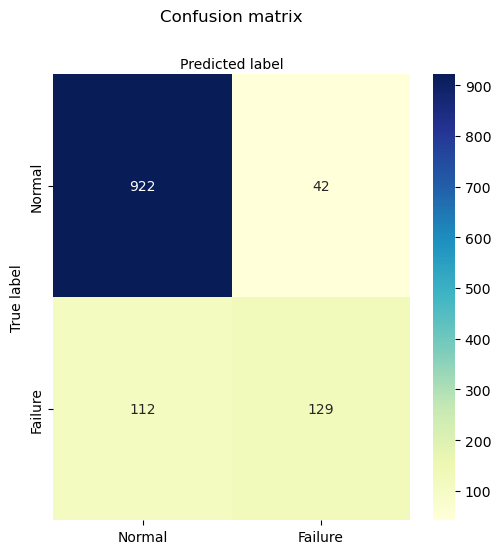

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# define the model
lgr=LogisticRegression()

# define model parameters for tuning
lgr_params = {'penalty':['elasticnet'], 
              'C':[0.1, 0.5, 1.0],
              'l1_ratio':[0,0.1,0.5,0.9,0.95,0.99,1], 
              'solver':['saga'], 
              'class_weight':[None, {0:1,1:1}, {0:1,1:1.01},{0:1,1:1.05},{0:1,1:1.1},{0:1,1:1.5}],
              'random_state':[0]}

# fit model
lgr_model=fit_tune(lgr,
               X_train,
               Y_train,
               lgr_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(lgr_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Linear Discriminant Analysis (LDA)

LinearDiscriminantAnalysis in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Best model parameters: {'solver': 'svd'}
Training time: 0.001 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93       964
     Failure       0.76      0.58      0.66       241

    accuracy                           0.88      1205
   macro avg       0.83      0.77      0.79      1205
weighted avg       0.87      0.88      0.87      1205

Task-level report:
ACC    0.880
AUC    0.889
F1     0.657
dtype: float64 



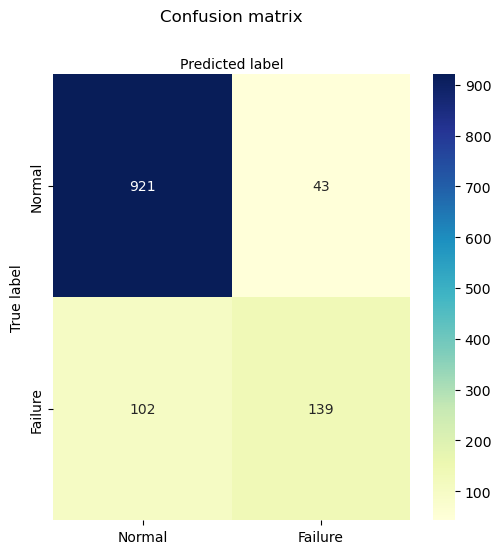

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# model fitting and tuning
lda = LinearDiscriminantAnalysis()

lda_params = {'solver':['svd', 'lsqr']}

lda_model=fit_tune(lda,
               X_train,
               Y_train,
               lda_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(lda_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Quadratic Descriminant Analysis (QDA)

QuadraticDiscriminantAnalysis in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

Best model parameters: {'reg_param': 0.1}
Training time: 0.001 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.93       964
     Failure       0.79      0.53      0.64       241

    accuracy                           0.88      1205
   macro avg       0.84      0.75      0.78      1205
weighted avg       0.87      0.88      0.87      1205

Task-level report:
ACC    0.878
AUC    0.924
F1     0.635
dtype: float64 



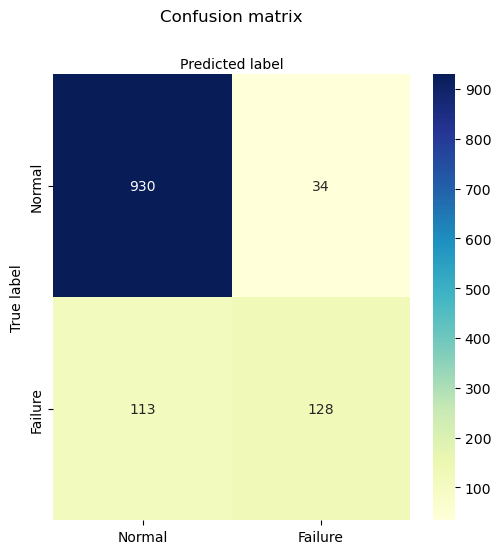

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# model fitting and tuning
qda=QuadraticDiscriminantAnalysis()

qda_params = {'reg_param':[0.0,0.1,0.5]}

qda_model=fit_tune(qda,
               X_train,
               Y_train,
               qda_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(qda_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Gaussian Naive Bayes (GNB)

GaussianNB in Scikit-learn: 

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

Best model parameters: {'priors': [0.8, 0.2], 'var_smoothing': 1e-10}
Training time: 0.001 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.91      0.93      0.92       964
     Failure       0.69      0.62      0.65       241

    accuracy                           0.87      1205
   macro avg       0.80      0.77      0.79      1205
weighted avg       0.86      0.87      0.87      1205

Task-level report:
ACC    0.868
AUC    0.863
F1     0.652
dtype: float64 



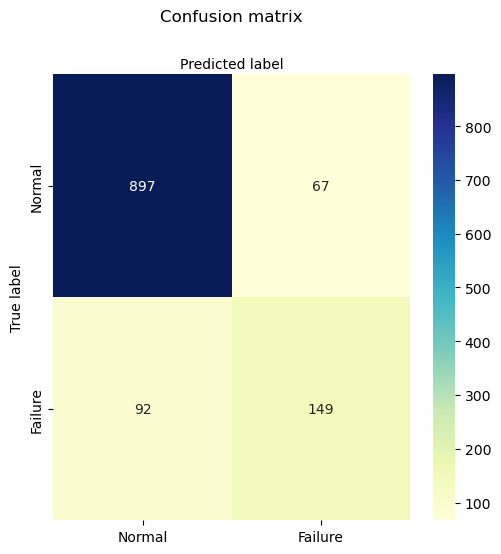

In [21]:
from sklearn.naive_bayes import GaussianNB

# model fitting and tuning
gnb = GaussianNB()

gnb_params = {'var_smoothing':[1e-10,1e-09,1e-7],
             'priors':[None, [0.8,0.2]]}

gnb_model=fit_tune(gnb,
               X_train,
               Y_train,
               gnb_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(gnb_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Support Vector Machine (SVM)

SVC in Scikit-learn:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Best model parameters: {'C': 200, 'gamma': 'scale', 'probability': True, 'random_state': 0}
Training time: 0.337 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       964
     Failure       0.89      0.95      0.92       241

    accuracy                           0.97      1205
   macro avg       0.94      0.96      0.95      1205
weighted avg       0.97      0.97      0.97      1205

Task-level report:
ACC    0.968
AUC    0.994
F1     0.922
dtype: float64 



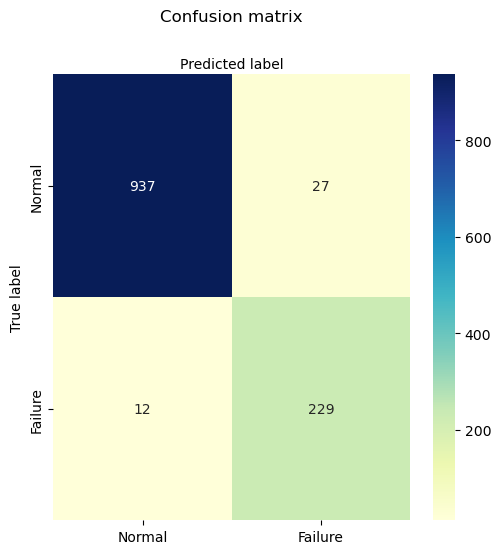

In [22]:
from sklearn.svm import SVC

# model fitting and tuning
svm = SVC()
svm_params = {'C':[50,200],
              'gamma': ['auto','scale'],
              'probability':[True], 
              'random_state':[0]}

svm_model=fit_tune(svm,
               X_train,
               Y_train,
               svm_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(svm_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)


### Decision Tree

DecisionTreeClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Best model parameters: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_features': None, 'random_state': 0, 'splitter': 'best'}
Training time: 0.025 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       964
     Failure       0.93      0.93      0.93       241

    accuracy                           0.97      1205
   macro avg       0.95      0.96      0.95      1205
weighted avg       0.97      0.97      0.97      1205

Task-level report:
ACC    0.971
AUC    0.955
F1     0.928
dtype: float64 



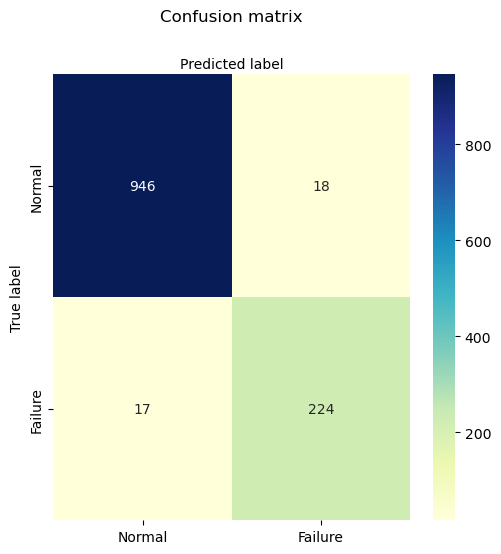

[Text(0.5, 0.875, 'x[4] <= 1.277\ngini = 0.32\nsamples = 9644\nvalue = [7714, 1930]'),
 Text(0.25, 0.625, 'x[3] <= 1.439\ngini = 0.23\nsamples = 8391\nvalue = [7280, 1111]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= -2.335\ngini = 0.144\nsamples = 7707\nvalue = [7103, 604]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[3] <= 1.998\ngini = 0.384\nsamples = 684\nvalue = [177.0, 507.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[3] <= 0.838\ngini = 0.453\nsamples = 1253\nvalue = [434.0, 819.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[4] <= 1.337\ngini = 0.493\nsamples = 962\nvalue = [424, 538]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[6] <= 0.5\ngini = 0.066\nsamples = 291\nvalue = [10, 281]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

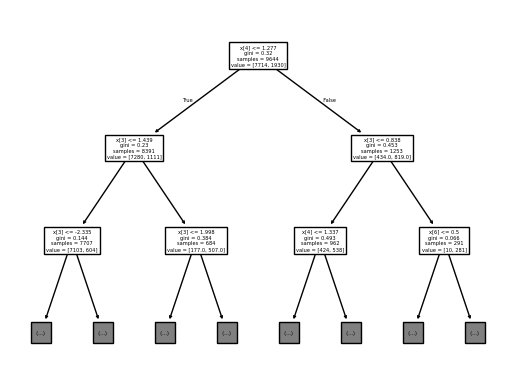

In [23]:
from sklearn.tree import DecisionTreeClassifier

# model fitting and tuning
dtc = DecisionTreeClassifier()

dtc_params = {'criterion':['gini','entropy','log_loss'],
              'splitter':['best','random'],
              'class_weight':[{0:1,1:1},{0:1,1:2}],
              'max_features':[None,'sqrt', 'log2', 4],  
              'random_state':[0]}

dtc_model=fit_tune(dtc,
               X_train,
               Y_train,
               dtc_params,
               'binary')


# model evaluation on the validation set
cm, scores = eval_pred(dtc_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

from sklearn import tree
#dtc.fit(X_train,Y_train['Machine failure''])
tree.plot_tree(DecisionTreeClassifier(random_state=0).fit(X_train,Y_train['Machine failure']),
               max_depth=2)

### Bagging

BaggingClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Best model parameters: {'n_estimators': 50, 'random_state': 0}
Training time: 0.136 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       964
     Failure       0.95      0.98      0.97       241

    accuracy                           0.99      1205
   macro avg       0.97      0.98      0.98      1205
weighted avg       0.99      0.99      0.99      1205

Task-level report:
ACC    0.986
AUC    0.997
F1     0.965
dtype: float64 



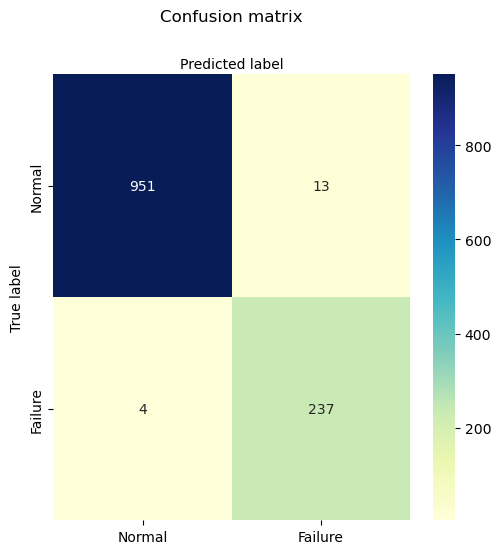

In [24]:
from sklearn.ensemble import BaggingClassifier

# model fitting and tuning
bgc = BaggingClassifier()

bgc_params ={'n_estimators':[10,20,50,100],
             'random_state':[0]}

bgc_model = fit_tune(bgc,
                 X_train,
                 Y_train,
                 bgc_params,
                 'binary')

# model evaluation on the validation set
cm, scores = eval_pred(bgc_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Ada Boosting

AdaBoostClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Best model parameters: {'learning_rate': 1, 'n_estimators': 100, 'random_state': 0}
Training time: 0.150 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.92      0.97      0.95       964
     Failure       0.84      0.68      0.75       241

    accuracy                           0.91      1205
   macro avg       0.88      0.82      0.85      1205
weighted avg       0.91      0.91      0.91      1205

Task-level report:
ACC    0.910
AUC    0.970
F1     0.751
dtype: float64 



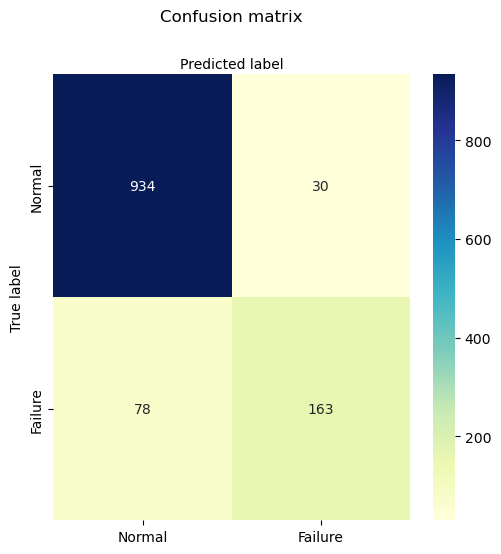

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# model fitting and tuning
adb = AdaBoostClassifier()

adb_params ={'n_estimators':[20,50,100],
             'learning_rate':[0.1,0.5,1,2],
             'random_state':[0]}

adb_model = fit_tune(adb,
                 X_train,
                 Y_train,
                 adb_params,
                 'binary')

# model evaluation on the validation set
cm, scores = eval_pred(adb_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Gradient Boosting Classifier

GradientBoostingClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Best model parameters: {'learning_rate': 0.15, 'n_estimators': 200, 'random_state': 0}
Training time: 0.285 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       964
     Failure       0.94      0.95      0.95       241

    accuracy                           0.98      1205
   macro avg       0.97      0.97      0.97      1205
weighted avg       0.98      0.98      0.98      1205

Task-level report:
ACC    0.979
AUC    0.996
F1     0.948
dtype: float64 



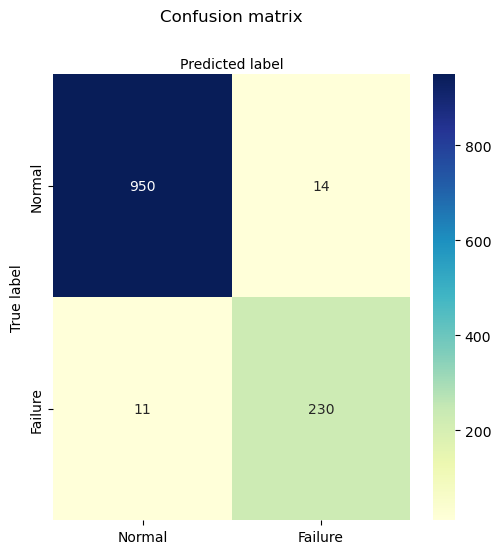

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# model fitting and tuning
gbc = GradientBoostingClassifier()

gbc_params ={'n_estimators':[100, 200],
             'learning_rate':[0.1, 0.15],
             'random_state':[0]}

gbc_model = fit_tune(gbc,
                 X_train,
                 Y_train,
                 gbc_params,
                 'binary')

# model evaluation on the validation set
cm, scores = eval_pred(gbc_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Random Forest

RandomForestClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Best model parameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 50, 'random_state': 0}
Training time: 0.474 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       964
     Failure       0.94      0.99      0.96       241

    accuracy                           0.99      1205
   macro avg       0.97      0.99      0.98      1205
weighted avg       0.99      0.99      0.99      1205

Task-level report:
ACC    0.985
AUC    0.998
F1     0.964
dtype: float64 



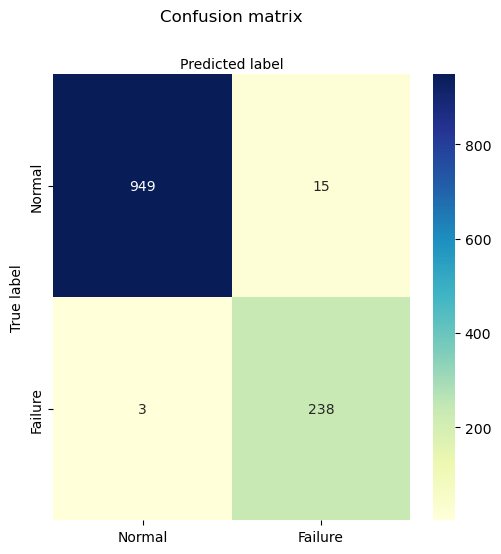

In [27]:
from sklearn.ensemble import RandomForestClassifier

# model fitting and tuning
rfc = RandomForestClassifier()

rfc_params = {'n_estimators':[10,50,100], 
              'criterion':['gini','log_loss'],
              'max_features':[None,'sqrt','log2'],  
              'random_state':[0]}

rfc_model=fit_tune(rfc,
               X_train,
               Y_train,
               rfc_params,
               'binary')

# model evaluation on the validation set
cm, scores = eval_pred(rfc_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Stacking

StackingClassifier in Scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

Best model parameters: {'rfc__criterion': 'log_loss', 'rfc__max_features': None, 'rfc__n_estimators': 50, 'svm__C': 200}
Training time: 2.602 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       964
     Failure       0.96      0.98      0.97       241

    accuracy                           0.99      1205
   macro avg       0.98      0.99      0.98      1205
weighted avg       0.99      0.99      0.99      1205

Task-level report:
ACC    0.988
AUC    0.998
F1     0.971
dtype: float64 



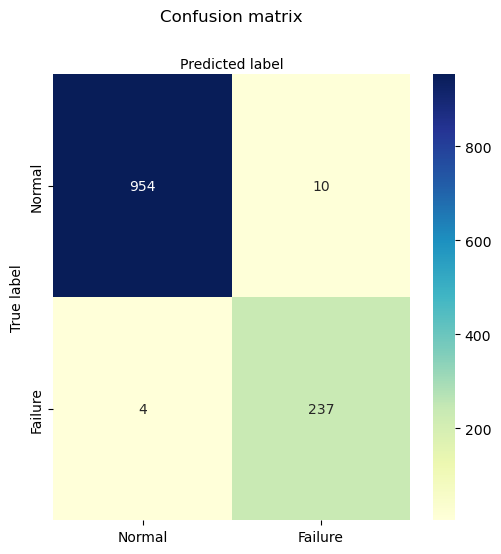

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


estimators = [('rfc', RandomForestClassifier(random_state=10)),
              ('svm', SVC(random_state=10))]

stk_params = {
    'rfc__n_estimators': [10, 50],
    'rfc__criterion': ['gini', 'log_loss'],
    'rfc__max_features': [None, 'sqrt'],
    'svm__C':[50,200]
}

stk = StackingClassifier(estimators=estimators)

stk_model=fit_tune(stk,
                   X_train,
                   Y_train,
                   stk_params,
                   'binary')

# model evaluation on the validation set
cm, scores = eval_pred(stk_model,
                       X_val,
                       Y_val,
                       task='binary',
                       disp=True)

### Comparison on the test dataset

In [29]:
models_ids = ['lgr','lda','qda','gnb','svm','dtc','bgc','adb','gbc','rfc','stk']
models=[lgr_model,lda_model,qda_model,gnb_model,svm_model,dtc_model,bgc_model,adb_model,gbc_model,rfc_model,stk_model]

_, _, scores = predict_and_evaluate(models,
                                               X_test,
                                               Y_test,
                                               models_ids,
                                               'binary')

print('Comparison of clssasification models on the test dataset:')
print(scores)


Comparison of clssasification models on the test dataset:
       lgr    lda    qda    gnb    svm    dtc    bgc    adb    gbc    rfc  \
ACC  0.876  0.880  0.877  0.867  0.973  0.975  0.986  0.899  0.980  0.984   
AUC  0.910  0.901  0.927  0.874  0.993  0.964  0.998  0.968  0.995  0.998   
F1   0.639  0.662  0.635  0.646  0.936  0.938  0.965  0.723  0.951  0.961   

       stk  
ACC  0.983  
AUC  0.999  
F1   0.959  


## Multiclass Classification

Features:
<ol>
 <li>   Air temperature [K]      float64</il>
 <li>   Process temperature [K]  float64</il>
 <li>   Rotational speed [rpm]   float64</il>
 <li>   Torque [Nm]              float64</il>
 <li>   Tool wear [min]          float64</il>
 <li>   Type_L                   int64</li>
 <li>   Type_M                   int64</li>
 <li>   Type_H                   int64</li>
</ol>



Response:
<ol>
<li> Failure mode          int64</il>
</ol>

### Multinomial Logistic regression

Best model parameters: {'C': 1, 'class_weight': {0: 1, 1: 2, 2: 2, 3: 2, 4: 2}, 'l1_ratio': 1, 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
Training time: 1.263 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       964
         TWF       0.56      0.70      0.62        61
         HDF       0.86      0.92      0.89        60
         PWF       0.92      1.00      0.96        60
         DSF       0.92      1.00      0.96        60

    accuracy                           0.94      1205
   macro avg       0.85      0.91      0.88      1205
weighted avg       0.94      0.94      0.94      1205

Task-level report:
ACC    0.939
AUC    0.987
F1     0.941
dtype: float64 



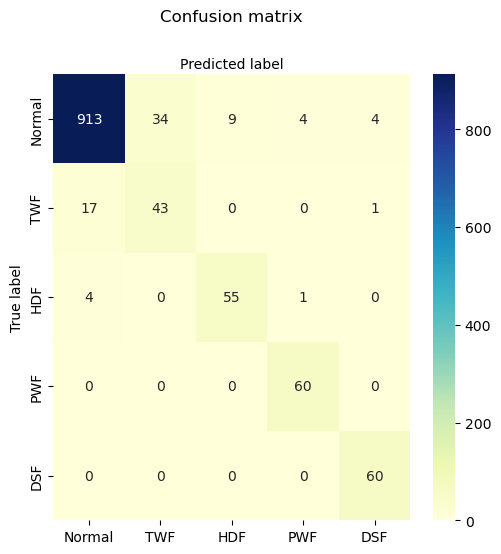

In [30]:
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression

# model fitting and tuning
lgr=LogisticRegression()
lgr_params = {'penalty':['elasticnet'], 
              'C':[0.1, 0.5,1],
              'l1_ratio':[0,0.9,1], 
              'solver':['saga'],
              'class_weight':[None, {0:1,1:4,2:4,3:4,4:4},{0:1,1:2,2:2,3:2,4:2}],
              'max_iter': [1000],
              'random_state':[0]}

lgr_model=fit_tune(lgr,
               X_train,
               Y_train,
               lgr_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(lgr_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Linear Discriminant Analysis (LDA)

Best model parameters: {'solver': 'lsqr'}
Training time: 0.001 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94       964
         TWF       0.00      0.00      0.00        61
         HDF       0.82      0.45      0.58        60
         PWF       0.84      0.82      0.83        60
         DSF       0.74      0.83      0.78        60

    accuracy                           0.89      1205
   macro avg       0.66      0.62      0.63      1205
weighted avg       0.84      0.89      0.86      1205

Task-level report:
ACC    0.888
AUC    0.970
F1     0.861
dtype: float64 



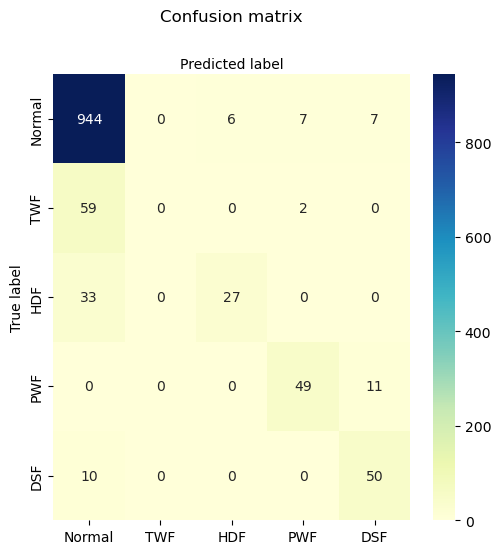

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# model fitting and tuning
lda = LinearDiscriminantAnalysis()

lda_params = {'solver':['svd', 'lsqr']}

lda_model=fit_tune(lda,
               X_train,
               Y_train,
               lda_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(lda_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Quadratic Descriminant Analysis (QDA)

Best model parameters: {'reg_param': 0.05}
Training time: 0.001 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96       964
         TWF       0.62      0.59      0.61        61
         HDF       0.79      0.95      0.86        60
         PWF       0.87      0.98      0.92        60
         DSF       0.77      1.00      0.87        60

    accuracy                           0.93      1205
   macro avg       0.80      0.89      0.84      1205
weighted avg       0.93      0.93      0.93      1205

Task-level report:
ACC    0.926
AUC    0.980
F1     0.927
dtype: float64 



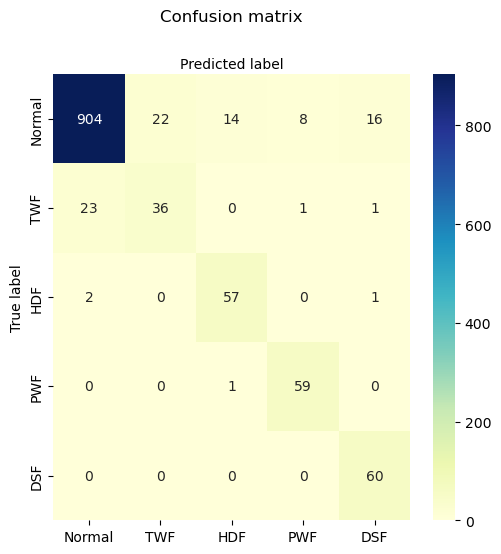

In [32]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# model fitting and tuning
qda=QuadraticDiscriminantAnalysis()

qda_params = {'reg_param':[0.0,0.05,0.1,0.7]}

qda_model=fit_tune(qda,
               X_train,
               Y_train,
               qda_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(qda_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Gaissian Naive Bayes (GNB)

Best model parameters: {'var_smoothing': 1e-09}
Training time: 0.000 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.96      0.88      0.91       964
         TWF       0.54      0.49      0.51        61
         HDF       0.64      0.87      0.74        60
         PWF       0.55      0.78      0.65        60
         DSF       0.58      0.98      0.73        60

    accuracy                           0.86      1205
   macro avg       0.65      0.80      0.71      1205
weighted avg       0.88      0.86      0.86      1205

Task-level report:
ACC    0.856
AUC    0.944
F1     0.863
dtype: float64 



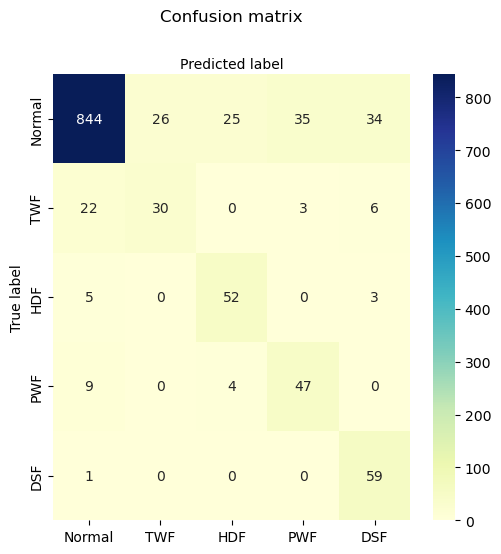

In [33]:
from sklearn.naive_bayes import GaussianNB

# model fitting and tuning
gnb = GaussianNB()

gnb_params = {'var_smoothing':[1e-09,1e-7]}

gnb_model=fit_tune(gnb,
               X_train,
               Y_train,
               gnb_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(gnb_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Support Vector Machine (SVM)

Best model parameters: {'C': 150, 'gamma': 'scale', 'probability': True, 'random_state': 0}
Training time: 0.405 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       964
         TWF       0.79      0.89      0.84        61
         HDF       0.94      0.97      0.95        60
         PWF       0.95      0.98      0.97        60
         DSF       1.00      1.00      1.00        60

    accuracy                           0.97      1205
   macro avg       0.93      0.96      0.95      1205
weighted avg       0.98      0.97      0.97      1205

Task-level report:
ACC    0.974
AUC    0.996
F1     0.975
dtype: float64 



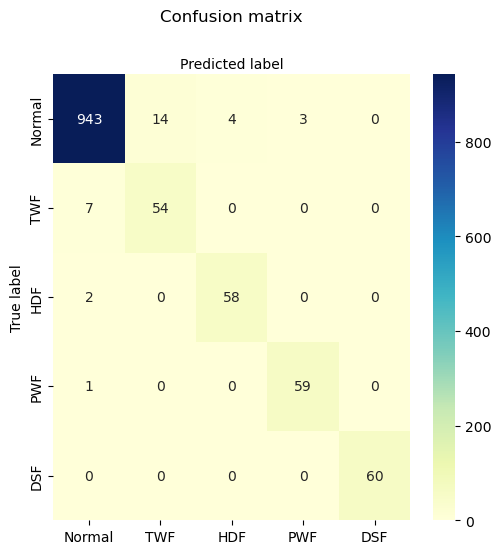

In [34]:
from sklearn.svm import SVC

# model fitting and tuning
svm = SVC()

svm_params = {'C':[50,100,150],
              #'gamma':[0.05,0.1,1], 
              'gamma': ['auto','scale'],
              'probability':[True], 
              'random_state':[0]}

svm_model=fit_tune(svm,
               X_train,
               Y_train,
               svm_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(svm_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)


### Decision Tree

Best model parameters: {'class_weight': None, 'criterion': 'entropy', 'max_features': None, 'random_state': 0, 'splitter': 'best'}
Training time: 0.041 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       964
         TWF       0.82      0.89      0.85        61
         HDF       0.92      0.95      0.93        60
         PWF       0.97      0.98      0.98        60
         DSF       0.95      0.97      0.96        60

    accuracy                           0.97      1205
   macro avg       0.93      0.95      0.94      1205
weighted avg       0.97      0.97      0.97      1205

Task-level report:
ACC    0.972
AUC    0.965
F1     0.972
dtype: float64 



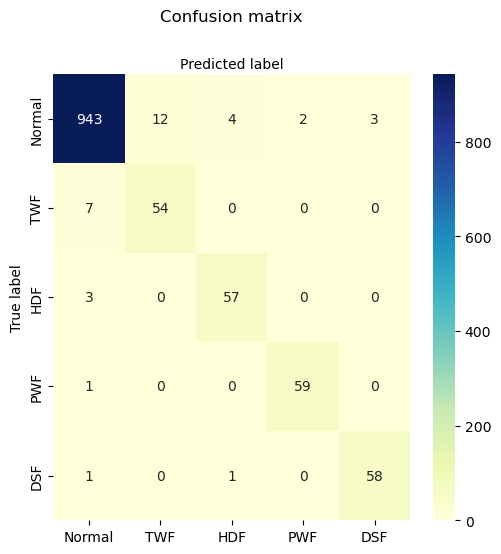

[Text(0.5, 0.875, 'x[4] <= 1.277\ngini = 0.32\nsamples = 9644\nvalue = [7714, 1930]'),
 Text(0.25, 0.625, 'x[3] <= 1.439\ngini = 0.23\nsamples = 8391\nvalue = [7280, 1111]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[3] <= -2.335\ngini = 0.144\nsamples = 7707\nvalue = [7103, 604]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[3] <= 1.998\ngini = 0.384\nsamples = 684\nvalue = [177.0, 507.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[3] <= 0.838\ngini = 0.453\nsamples = 1253\nvalue = [434.0, 819.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[4] <= 1.337\ngini = 0.493\nsamples = 962\nvalue = [424, 538]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[6] <= 0.5\ngini = 0.066\nsamples = 291\nvalue = [10, 281]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

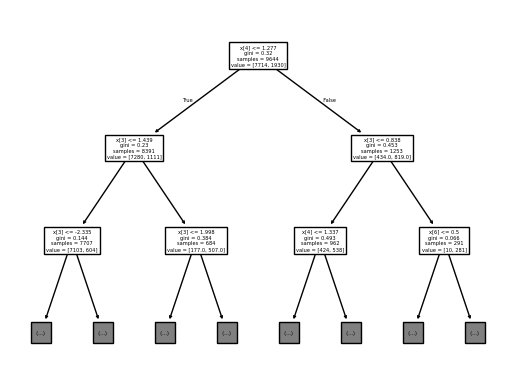

In [35]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree

# model fitting and tuning
dtc = DecisionTreeClassifier()

dtc_params = {'criterion':['gini','entropy','log_loss'],
              'splitter':['best','random'],
              'class_weight':[None, {0:1,1:4,2:4,3:4,4:4},{0:1,1:2,2:2,3:2,4:2}],
              'max_features':[None,'sqrt', 'log2', 4],  
              'random_state':[0]}

dtc_model=fit_tune(dtc,
               X_train,
               Y_train,
               dtc_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(dtc_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

from sklearn import tree
#dtc.fit(X_train,Y_train['Machine failure''])
tree.plot_tree(DecisionTreeClassifier(random_state=0).fit(X_train,Y_train['Machine failure']),
               max_depth=2)

### Bagging

Best model parameters: {'n_estimators': 100, 'random_state': 0}
Training time: 0.174 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       964
         TWF       0.95      0.93      0.94        61
         HDF       0.93      0.95      0.94        60
         PWF       0.97      0.98      0.98        60
         DSF       0.94      1.00      0.97        60

    accuracy                           0.98      1205
   macro avg       0.96      0.97      0.96      1205
weighted avg       0.98      0.98      0.98      1205

Task-level report:
ACC    0.983
AUC    0.997
F1     0.983
dtype: float64 



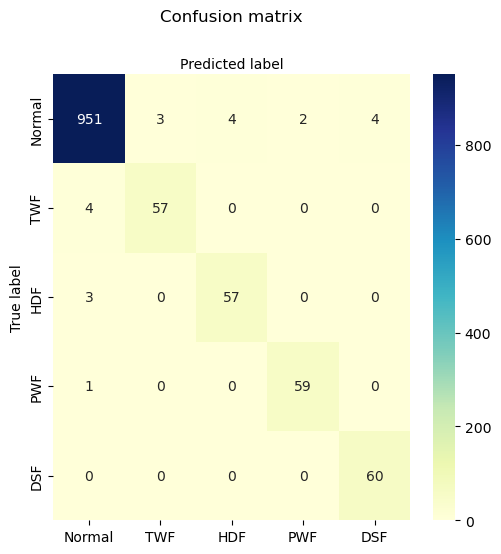

In [36]:
from sklearn.ensemble import BaggingClassifier

# model fitting and tuning
bgc = BaggingClassifier()

bgc_params ={'n_estimators':[10,20,50,100],
             'random_state':[0]}

bgc_model = fit_tune(bgc,
                 X_train,
                 Y_train,
                 bgc_params,
                 'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(bgc_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Ada Boosting

Best model parameters: {'learning_rate': 1, 'n_estimators': 100, 'random_state': 0}
Training time: 0.158 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95       964
         TWF       0.71      0.20      0.31        61
         HDF       0.62      0.58      0.60        60
         PWF       0.96      0.78      0.86        60
         DSF       0.93      0.88      0.91        60

    accuracy                           0.90      1205
   macro avg       0.83      0.68      0.73      1205
weighted avg       0.89      0.90      0.89      1205

Task-level report:
ACC    0.903
AUC    0.966
F1     0.890
dtype: float64 



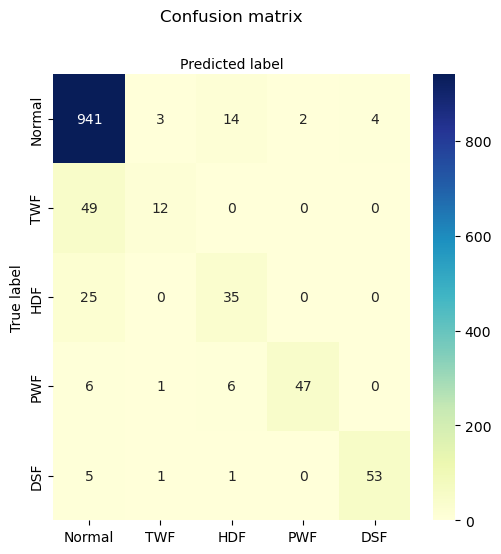

In [37]:
from sklearn.ensemble import AdaBoostClassifier

# model fitting and tuning
adb = AdaBoostClassifier()

adb_params ={'n_estimators':[20,50,100],
             'learning_rate':[0.1,0.5,1,2],
             'random_state':[0]}

adb_model = fit_tune(adb,
                 X_train,
                 Y_train,
                 adb_params,
                 'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(adb_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Gradient Boosting Classifier

Best model parameters: {'learning_rate': 0.15, 'n_estimators': 200, 'random_state': 0}
Training time: 1.573 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       964
         TWF       0.98      0.92      0.95        61
         HDF       0.98      0.98      0.98        60
         PWF       0.97      0.97      0.97        60
         DSF       0.94      1.00      0.97        60

    accuracy                           0.99      1205
   macro avg       0.97      0.97      0.97      1205
weighted avg       0.99      0.99      0.99      1205

Task-level report:
ACC    0.988
AUC    0.998
F1     0.988
dtype: float64 



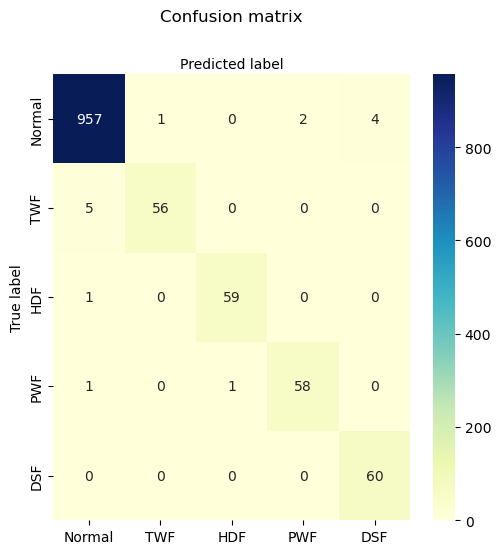

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# model fitting and tuning
gbc = GradientBoostingClassifier()

gbc_params ={'n_estimators':[100, 200],
             'learning_rate':[0.1, 0.15],
             'random_state':[0]}

gbc_model = fit_tune(gbc,
                 X_train,
                 Y_train,
                 gbc_params,
                 'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(gbc_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Random Forest

Best model parameters: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100, 'random_state': 0}
Training time: 0.513 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       964
         TWF       0.92      0.93      0.93        61
         HDF       0.95      0.95      0.95        60
         PWF       0.97      1.00      0.98        60
         DSF       0.97      1.00      0.98        60

    accuracy                           0.98      1205
   macro avg       0.96      0.97      0.97      1205
weighted avg       0.98      0.98      0.98      1205

Task-level report:
ACC    0.984
AUC    0.998
F1     0.984
dtype: float64 



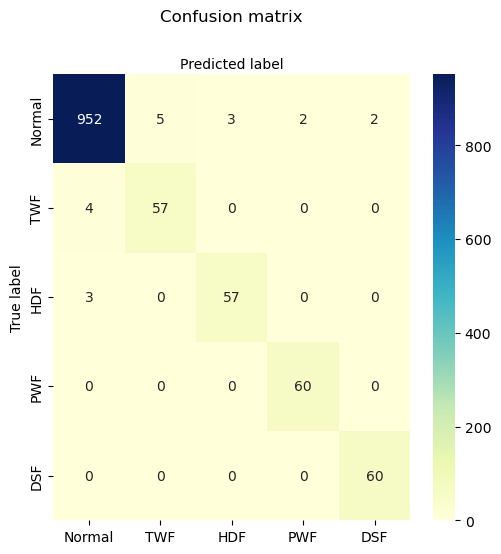

In [39]:
from sklearn.ensemble import RandomForestClassifier

# model fitting and tuning
rfc = RandomForestClassifier()

rfc_params = {'n_estimators':[10,50,100], 
              'criterion':['gini','log_loss'],
              'max_features':[None,'sqrt','log2'],  
              'random_state':[0]}

rfc_model= fit_tune(rfc,
               X_train,
               Y_train,
               rfc_params,
               'multi_class')

# model evaluation on the validation set
cm, scores = eval_pred(rfc_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)


### Stacking

Best model parameters: {'rfc__criterion': 'gini', 'rfc__max_features': None, 'rfc__n_estimators': 50, 'svm__C': 1, 'svm__penalty': 'l1'}
Training time: 2.389 min

 Class-level report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       964
         TWF       0.94      0.97      0.95        61
         HDF       0.95      0.95      0.95        60
         PWF       0.97      0.97      0.97        60
         DSF       0.97      1.00      0.98        60

    accuracy                           0.99      1205
   macro avg       0.96      0.97      0.97      1205
weighted avg       0.99      0.99      0.99      1205

Task-level report:
ACC    0.986
AUC    0.998
F1     0.986
dtype: float64 



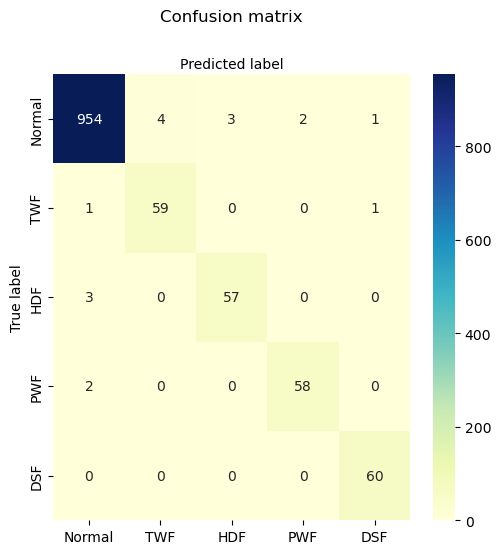

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# model fitting and tuning
estimators = [('rfc', RandomForestClassifier(random_state=10)),
              ('svm', LinearSVC(random_state=10))]

stk_params = {
    'rfc__n_estimators': [10, 50],
    'rfc__criterion': ['gini'],
    'rfc__max_features': [None],
    'svm__C':[1, 50,200],
    'svm__penalty':['l1', 'l2']
}

stk = StackingClassifier(estimators=estimators)


stk_model=fit_tune(stk,
               X_train,
               Y_train,
               stk_params,
               'multi_class')


# model evaluation on the validation set
cm, scores = eval_pred(stk_model,
                       X_val,
                       Y_val,
                       task='multi_class',
                       disp=True)

### Comparison on the test dataset

In [41]:
models_ids = ['lgr','lda','qda','gnb','svm','dtc','bgc','adb','gbc','rfc','stk']
fitted_models=[lgr_model,lda_model,qda_model,gnb_model,svm_model,dtc_model,bgc_model,adb_model,gbc_model,rfc_model,stk_model]

y_pred, cm_dict, scores=predict_and_evaluate(fitted_models,
                                             X_test,
                                             Y_test,
                                             models_ids,
                                             'multi_class')

print('Comparison of clssasification models on the test dataset:')
print(scores)


Comparison of clssasification models on the test dataset:
       lgr    lda    qda    gnb    svm    dtc    bgc    adb    gbc    rfc  \
ACC  0.940  0.891  0.925  0.874  0.983  0.978  0.987  0.894  0.989  0.985   
AUC  0.984  0.965  0.976  0.952  0.997  0.973  0.998  0.960  0.998  0.999   
F1   0.943  0.865  0.927  0.882  0.984  0.978  0.987  0.879  0.989  0.985   

       stk  
ACC  0.987  
AUC  0.997  
F1   0.987  
